<a href="https://colab.research.google.com/github/Soccolo/CVAE/blob/main/PriorVAE_2d_GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing libraries

In [1]:
# instructions from here: https://colab.research.google.com/drive/1c_RGCgQeLHVXlF44LyOFjfUW32CmG6BP#scrollTo=LAZ11nESX6qt
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:10
🔁 Restarting kernel...


In [1]:
!conda install jax==0.2.17 numpyro==0.7.1 -c conda-forge

Solving environment: \ failed with initial frozen solve. Retrying with flexible solve.
Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated sp

In [30]:
# general libraries
import time
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import arviz as az

# JAX
import jax.numpy as jnp
from jax import random, lax, jit, ops
from jax.experimental import stax

from functools import partial

# Numpyro
import numpyro
import numpyro.distributions as dist
from numpyro import optim
from numpyro.infer import SVI, Trace_ELBO, MCMC, NUTS, init_to_median, Predictive
from numpyro.diagnostics import hpdi

import pickle

## Sample Gaussian Process

In [3]:
def dist_euclid(x, z):
    x = jnp.array(x) 
    z = jnp.array(z)
    if len(x.shape)==1:
        x = x.reshape(x.shape[0], 1)
    if len(z.shape)==1:
        z = x.reshape(x.shape[0], 1)
    n_x, m = x.shape
    n_z, m_z = z.shape
    assert m == m_z
    delta = jnp.zeros((n_x,n_z))
    for d in jnp.arange(m):
        x_d = x[:,d]
        z_d = z[:,d]
        delta += (x_d[:,jnp.newaxis] - z_d)**2
    return jnp.sqrt(delta)


def exp_sq_kernel(x, z, var, length, noise=0, jitter=1.0e-6):
    dist = dist_euclid(x, z)
    deltaXsq = jnp.power(dist/ length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    k += (noise + jitter) * jnp.eye(x.shape[0])
    return k


def GP(gp_kernel, x, jitter=1e-5, var=None, length=None, y=None, noise=False):
    
    if length==None:
        length = numpyro.sample("kernel_length", dist.InverseGamma(4,1))
        
    if var==None:
        var = numpyro.sample("kernel_var", dist.LogNormal(0.,0.1))
        
    k = gp_kernel(x, x, var, length, jitter)
    
    if noise==False:
        numpyro.sample("y",  dist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k), obs=y)
    else:
        sigma = numpyro.sample("noise", dist.HalfNormal(0.1))
        f = numpyro.sample("f", dist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k))
        numpyro.sample("y", dist.Normal(f, sigma), obs=y)

In [4]:
args = {"n": 25,
        "gp_kernel": exp_sq_kernel,
        "rng_key": random.PRNGKey(2),
        "batch_size": 5
}

# create grid and draw priors
x = [jnp.array((i, j)) for i in jnp.arange(0, 1, 1/args["n"]) for j in jnp.arange(0, 1, 1/args["n"])]
x = jnp.asarray(x, dtype = np.float32)
rng_key, rng_key_predict = random.split(random.PRNGKey(4))
gp_predictive = Predictive(GP, num_samples=args["batch_size"])
gp_draws = gp_predictive(rng_key_predict, x=x, gp_kernel = args["gp_kernel"], jitter=1e-5)['y']

In [ ]:
z = gp_draws[1].reshape((25, 25))

In [5]:
def heatmap2d(arr):
    plt.imshow(arr, cmap='viridis')
    plt.colorbar()
    plt.show()

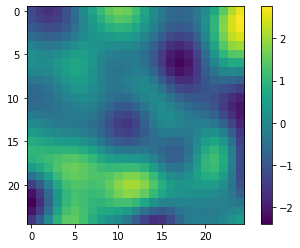

In [ ]:
heatmap2d(z)

## Applying VAE

In [6]:
def vae_encoder(hidden_dim1, hidden_dim2, z_dim):
    return stax.serial(
        stax.Dense(hidden_dim1, W_init=stax.randn()),
        stax.Relu,
        stax.Dense(hidden_dim2, W_init=stax.randn()),
        stax.Relu,
        stax.FanOut(2),
        stax.parallel(
            stax.Dense(z_dim, W_init=stax.randn()), # mean
            stax.serial(stax.Dense(z_dim, W_init=stax.randn()), stax.Exp), # std -- i.e. diagonal covariance
        ),
    )


def vae_decoder(hidden_dim1, hidden_dim2, out_dim):
    return stax.serial(
        stax.Dense(hidden_dim1, W_init=stax.randn()),
        stax.Relu,
        stax.Dense(hidden_dim2, W_init=stax.randn()),
        stax.Relu,
        stax.Dense(out_dim, W_init=stax.randn()) 
    )


def vae_model(batch, hidden_dim1, hidden_dim2, z_dim):
    batch = jnp.reshape(batch, (batch.shape[0], -1))
    batch_dim, out_dim = jnp.shape(batch)
    decode = numpyro.module("decoder", vae_decoder(hidden_dim1, hidden_dim2, out_dim), (batch_dim, z_dim))
    z = numpyro.sample("z", dist.Normal(jnp.zeros((z_dim,)), jnp.ones((z_dim,))))
    gen_loc = decode(z)    
    return numpyro.sample("obs", dist.Normal(gen_loc, .1), obs=batch) 
    

def vae_guide(batch, hidden_dim1, hidden_dim2, z_dim):
    batch = jnp.reshape(batch, (batch.shape[0], -1))
    batch_dim, out_dim = jnp.shape(batch)
    encode = numpyro.module("encoder", vae_encoder(hidden_dim1, hidden_dim2, z_dim), (batch_dim, out_dim))
    z_loc, z_std = encode(batch)
    z = numpyro.sample("z", dist.Normal(z_loc, z_std))
    return z

@jit
def epoch_train(rng_key, svi_state, num_train):

    def body_fn(i, val):
        rng_key_i = random.fold_in(rng_key, i) 
        rng_key_i, rng_key_ls, rng_key_var, rng_key_noise = random.split(rng_key_i, 4)
        loss_sum, svi_state = val # val -- svi_state
        batch = gp_predictive(rng_key_i, gp_kernel=args["gp_kernel"], x=args["x"], jitter=1e-4)
        svi_state, loss = svi.update(svi_state, batch['y']) 
        loss_sum += loss / args['batch_size']
        return loss_sum, svi_state

    return lax.fori_loop(0, num_train, body_fn, (0.0, svi_state)) #fori_loop(lower, upper, body_fun, init_val)

@jit
def eval_test(rng_key, svi_state, num_test):

    def body_fn(i, loss_sum):
        rng_key_i = random.fold_in(rng_key, i) 
        rng_key_i, rng_key_ls, rng_key_var, rng_key_noise = random.split(rng_key_i, 4)
        batch = gp_predictive(rng_key_i, gp_kernel=args["gp_kernel"], x=args["x"], jitter=1e-4)
        loss = svi.evaluate(svi_state, batch['y']) / args['batch_size']
        loss_sum += loss
        return loss_sum

    loss = lax.fori_loop(0, num_test, body_fn, 0.0)
    loss = loss / num_test

    return loss

In [7]:
args = {"num_epochs": 100, 
        "learning_rate": 1.0e-3, 
        "batch_size": 100, 
        "hidden_dim1": 35,
        "hidden_dim2": 30,
        "z_dim": 30,
         "x": x,
        "n": 25,
        "gp_kernel": exp_sq_kernel,
        "rng_key": random.PRNGKey(1),
        "num_warmup": 1000,
        "num_samples": 1000,
        "num_chains": 4,
        "thinning": 1
        }

In [ ]:
adam = optim.Adam(step_size=args["learning_rate"])

svi = SVI(vae_model, vae_guide, adam, Trace_ELBO(), 
          hidden_dim1=args["hidden_dim1"], 
          hidden_dim2=args["hidden_dim2"], 
          z_dim=args["z_dim"])

rng_key, rng_key_samp, rng_key_init = random.split(args["rng_key"], 3)
init_batch = gp_predictive(rng_key_predict, x=args["x"], gp_kernel = args["gp_kernel"])['y']
svi_state = svi.init(rng_key_init, init_batch)

In [ ]:
test_loss_list = []

for i in range(args['num_epochs']):
    
    rng_key, rng_key_train, rng_key_test, rng_key_infer = random.split(rng_key, 4)
    
    t_start = time.time()

    num_train = 1000
    _, svi_state = epoch_train(rng_key_train, svi_state, num_train)

    num_test = 1000
    test_loss = eval_test(rng_key_test, svi_state, num_test)
    test_loss_list += [test_loss]

    print(
        "Epoch {}: loss = {} ({:.2f} s.)".format(
            i, test_loss, time.time() - t_start
        )
    )
    
    if math.isnan(test_loss): break

Epoch 0: loss = 994.3499145507812 (86.44 s.)
Epoch 1: loss = 999.909912109375 (73.03 s.)
Epoch 2: loss = 1022.107177734375 (70.64 s.)
Epoch 3: loss = 996.865478515625 (72.72 s.)
Epoch 4: loss = 988.0079956054688 (71.05 s.)
Epoch 5: loss = 780.5491333007812 (68.99 s.)
Epoch 6: loss = 732.6648559570312 (69.56 s.)
Epoch 7: loss = 571.7102661132812 (71.46 s.)
Epoch 8: loss = 554.7970581054688 (72.89 s.)
Epoch 9: loss = 558.4375610351562 (71.87 s.)
Epoch 10: loss = 564.170166015625 (71.60 s.)
Epoch 11: loss = 461.6415100097656 (73.19 s.)
Epoch 12: loss = 460.8251953125 (71.65 s.)
Epoch 13: loss = 466.6106872558594 (71.39 s.)
Epoch 14: loss = 464.5203857421875 (71.91 s.)
Epoch 15: loss = 454.5428161621094 (70.89 s.)
Epoch 16: loss = 391.1336669921875 (69.57 s.)
Epoch 17: loss = 379.3935241699219 (69.47 s.)
Epoch 18: loss = 372.6640319824219 (70.25 s.)
Epoch 19: loss = 372.55352783203125 (73.47 s.)
Epoch 20: loss = 388.1697998046875 (71.08 s.)
Epoch 21: loss = 382.3141174316406 (69.94 s.)
Epo

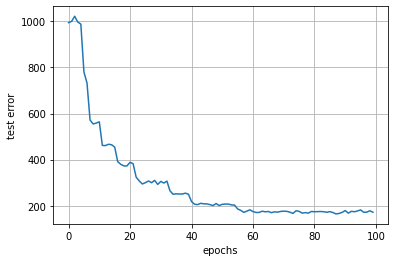

In [ ]:
plt.figure()
plt.grid()
plt.plot(np.arange(len(test_loss_list)), test_loss_list, label="test loss")
plt.xlabel("epochs")
plt.ylabel("test error")
plt.show()

In [ ]:
# To make the decoder available for future use, save after training:

decoder_params = svi.get_params(svi_state)["decoder$params"]
args["decoder_params"] = decoder_params 

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
with open('/content/gdrive/My Drive/M4R/decoder_2d_n25', 'wb') as file:
    pickle.dump(decoder_params, file)

NameError: ignored

In [9]:
#Load 
with open('/content/gdrive/My Drive/M4R/decoder_2d_n25', 'rb') as file:
    decoder_params = pickle.load(file)
    print(len(decoder_params))

args["decoder_params"] = decoder_params

5


## Obtain VAE samples

In [10]:
def vae_sample(z_dim=args["z_dim"]):
    z = numpyro.sample("z", dist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))
    decoder_nn = vae_decoder(args["hidden_dim2"], args["hidden_dim1"], len(args["x"]))  
    decoder_params = args["decoder_params"]
    f = numpyro.deterministic("f", decoder_nn[1](decoder_params, z))

In [ ]:
rng_key, rng_key_predict = random.split(random.PRNGKey(2))
vae_predictive = Predictive(vae_sample, num_samples=1000)
vae_draws = vae_predictive(rng_key_predict)['f']

In [ ]:
def mean_img(draws):
  sum = 0
  for img in draws:
    img = img.reshape((25, 25))
    sum = sum + img
  sum = sum/len(draws)
  return(sum)

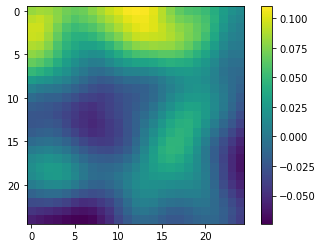

In [ ]:
heatmap2d(mean_img(vae_draws))

In [ ]:
sample_cov = jnp.cov(vae_draws, rowvar = False)

In [ ]:
length = 1
var = 0.1
jitter = 1e-5

In [ ]:
kernel_matrix = exp_sq_kernel(x, x, var, length, jitter)

In [ ]:
mse = (jnp.square(sample_cov - kernel_matrix)).mean(axis=None)

In [ ]:
mse

DeviceArray(0.00472506, dtype=float32)

In [ ]:
kernel_matrix.shape

(625, 625)

In [ ]:
y1 = kernel_matrix[0][0:25]
y2 = sample_cov[0][0:25]
x = [i for i in range(25)]

In [ ]:
y1

DeviceArray([0.100011  , 0.09992003, 0.09968051, 0.09928259, 0.09872816,
             0.09801987, 0.09716108, 0.09615584, 0.09500886, 0.0937255 ,
             0.09231164, 0.09077375, 0.08911879, 0.08735412, 0.08548751,
             0.08352702, 0.08148103, 0.07935807, 0.07716687, 0.07491621,
             0.07261491, 0.07027178, 0.06789553, 0.06549477, 0.06307788],            dtype=float32)

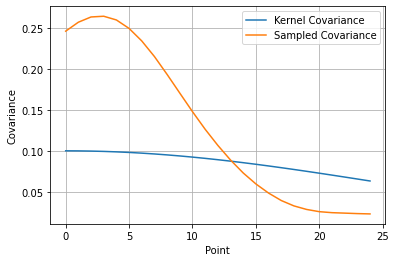

In [ ]:
plt.figure()
plt.grid()
plt.plot(x, y1, label="Kernel Covariance")
plt.plot(x, y2, label="Sampled Covariance")
plt.xlabel("Point")
plt.ylabel("Covariance")
plt.legend()
plt.show()

## Performing MCMC inference

In [11]:
!pip install pyreadr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.7/247.7 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.3/502.3 kB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 40.6 MB/s eta 0:00:00


In [12]:
import pyreadr

In [13]:
covimod = pyreadr.read_r('pop.Rdata')['pop_df']

Since we are doing male-female interactions, what we want from this database is a matrix of the female population of ages between 6 and 30.

In [14]:
covimod = covimod.to_numpy()

In [103]:
pop_matrix = np.zeros((25, 25))

In [160]:
for i in range(25):
  for j in range(25):
    pop_matrix[i][j] = covimod[107+i][2]

In [161]:
logP = np.log(pop_matrix)

In [162]:
logP = jnp.asarray(logP)

In [163]:
args['logP'] = logP

In [72]:
old_intensity = pyreadr.read_r('data.rds')[None]

In [78]:
def data_cut(dt):
  """
  Inputs:
  dt = pandas dataframe including all the gender interactions
  
  Outputs:
  dt_MF = pandas dataframe including only the male-female interactions
  """
  dt = dt.to_numpy()
  dt_MF = dt #Dataset only with contact intensities between males and females
  dt_MF_list = []
  for contact in dt_MF:
    if contact[1] == 'Female' and contact[4] == 'Male': #Male to female contacts
      if contact[0]<=30 and contact[2]<=30:
        contact = np.delete(contact, 1)
        contact = np.delete(contact, 3)
        dt_MF_list.append(contact)
  dt_MF = np.array(dt_MF_list)
  dt_MF = pd.DataFrame(dt_MF, columns = ['alter_age', 'age', 'cntct_intensity', 'cntct_rate', 'pop'], dtype = float)

  return dt_MF

In [76]:
dt = data_cut(old_intensity)

In [23]:
table = dt.pivot(index = 'alter_age', columns = 'age', values = 'cntct_intensity')

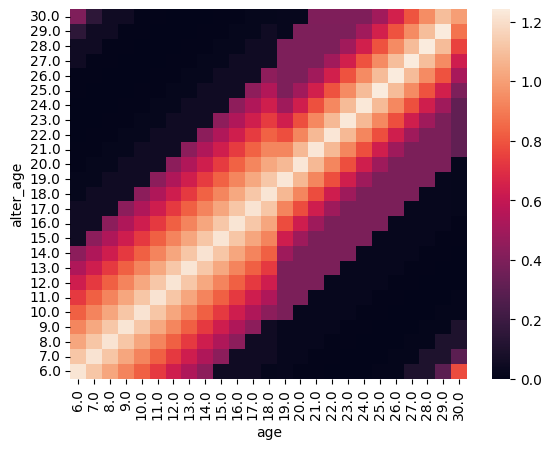

In [24]:
ax = sns.heatmap(table)
ax.invert_yaxis()
plt.show()

In [202]:
m = np.asarray(table)

In [139]:
old_participants = pyreadr.read_r('dt.rds')['dt']

In [95]:
def participants_matrix(dt):
  """
  Inputs:
  dt = pandas dataframe including all the gender interactions
  
  Outputs:
  dt_MF = pandas dataframe including number of male participants by age
  """
  dt = dt.to_numpy()
  dt_MF = dt #Dataset only with contact intensities between males and females
  dt_MF_list = []
  for contact in dt_MF:
    if contact[1] == 'Male' and contact[3] == 'Female': #Male to female contacts
      if contact[0]<=30 and contact[2]<=30:
        contact = np.delete(contact, 1)
        contact = np.delete(contact, 2)
        contact = np.delete(contact, 2)
        contact = np.delete(contact, 2)
        contact = np.delete(contact, 2)
        contact = np.delete(contact, 2)
        contact = np.delete(contact, 1)
        dt_MF_list.append(contact)
  dt_MF = np.array(dt_MF_list)
  dt_MF = pd.DataFrame(dt_MF, columns = ['age', 'part'], dtype = float)
  dt_MF = dt_MF.drop_duplicates()

  return dt_MF

In [97]:
part = np.asarray(participants_matrix(old_participants))

In [109]:
part_matrix = np.zeros((25, 25))

In [110]:
for i in range(25):
  for j in range(25):
    part_matrix[i][j] = part[j][1]

In [112]:
logN = jnp.log(jnp.asarray(part_matrix))

In [164]:
args['logN'] = logN

In [227]:
y = np.floor(np.multiply(m, part_matrix))

## Running MCMC

In [212]:
def contact_model_VAE(args, y = None):

  P = args['logP']
  N = args['logN']
  n = args['n']

  decoder_params = args["decoder_params"]
  z_dim, hidden_dim = decoder_params[0][0].shape
  z = numpyro.sample("z", dist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))
  decoder_nn = vae_decoder(args["hidden_dim2"], args["hidden_dim1"], n)
  f = numpyro.deterministic("f", decoder_nn[1](decoder_params, z))
  f = jnp.reshape(f, (25, 25))

  #fixed effects
  b0 = numpyro.sample('b0', dist.Normal(0, 10))
  v = numpyro.sample('v', dist.Exponential(1))
  tau = numpyro.sample('tau', dist.Normal(0, 1))
  rho = numpyro.sample('rho', dist.Normal(0, 1))

  lp = b0 + tau + f + P
  lu = lp + N + rho
  u = jnp.exp(lu)
  a = u/v
  
  if y is None:
    numpyro.sample("y_pred", dist.GammaPoisson(a, v/(1+v)))
  else:
    numpyro.sample("y", dist.GammaPoisson(a, v/(1+v)), obs=y)

In [213]:
rng_key, rng_key_predict = random.split(random.PRNGKey(6))

# inference
start = time.time()
kernel = NUTS(contact_model_VAE)
mcmc_vae = MCMC(kernel, num_warmup=2000, num_samples=3000, num_chains = args['num_chains'], thinning = args['thinning'])
mcmc_vae.run(rng_key, args, y = y),
t_elapsed = time.time() - start

prev_samples = mcmc_vae.get_samples()
#mcmc.print_summary()

/usr/local/lib/python3.9/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 5000/5000 [02:32<00:00, 32.68it/s, 255 steps of size 1.36e-02. acc. prob=0.93]


In [214]:
print("\nMCMC elapsed time:", round(t_elapsed), "s")
ss = numpyro.diagnostics.summary(mcmc_vae.get_samples(group_by_chain=True))
r = np.mean(ss['f']['n_eff'])
print("Average ESS for all VAE-CAR effects : " + str(round(r)))


MCMC elapsed time: 647 s
Average ESS for all VAE-CAR effects : 8960


In [215]:
mcmc_vae.print_summary(exclude_deterministic = False)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b0    -12.19      1.46    -12.20    -14.58     -9.76   6513.79      1.00
      f[0]      1.15      0.16      1.14      0.87      1.39  10175.05      1.00
      f[1]      1.19      0.17      1.19      0.90      1.46  10005.98      1.00
      f[2]      1.21      0.18      1.21      0.93      1.51   9829.67      1.00
      f[3]      1.21      0.19      1.21      0.91      1.53   9658.70      1.00
      f[4]      1.19      0.19      1.19      0.89      1.52   9491.82      1.00
      f[5]      1.15      0.20      1.14      0.84      1.49   9348.19      1.00
      f[6]      1.08      0.20      1.07      0.76      1.41   9237.65      1.00
      f[7]      0.98      0.20      0.98      0.66      1.32   9183.73      1.00
      f[8]      0.83      0.20      0.83      0.50      1.17   9171.01      1.00
      f[9]      0.63      0.21      0.63      0.30      0.97   9186.30      1.00
     f[10]      0.39      0

In [216]:
samples = mcmc_vae.get_samples()
b0 = samples['b0'][0]
rho = samples['rho'][0]
tau = samples['tau'][0]
f = samples['f'][0]
v = samples['v'][0]

In [217]:
f = f.reshape(25, 25)

In [219]:
lm = f + b0 + logP + tau

In [220]:
m_pred = jnp.exp(lm)

In [224]:
lu = lm + rho + logN

In [225]:
u = jnp.exp(lu)
a = u/v

In [228]:
rng_key, rng_key_predict = random.split(random.PRNGKey(6))
y_pred = numpyro.sample('y', dist.GammaPoisson(a, v/(1+v)), rng_key = rng_key)

In [230]:
np.abs(np.mean(y_pred-y))

0.0432

In [194]:
prev_samples_vae_az = az.from_numpyro(mcmc_vae)

array([[<Axes: title={'center': 'b0'}>, <Axes: title={'center': 'b0'}>]],
      dtype=object)

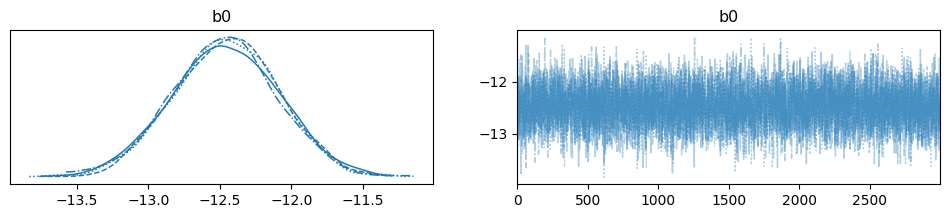

In [198]:
az.plot_trace(prev_samples_vae_az, var_names = ("b0"))

array([[<Axes: title={'center': 'v'}>, <Axes: title={'center': 'v'}>]],
      dtype=object)

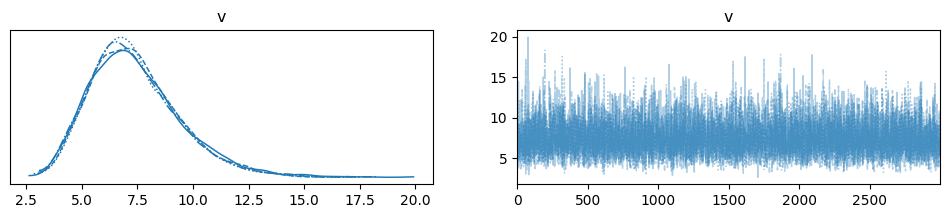

In [199]:
az.plot_trace(prev_samples_vae_az, var_names = ("v"))

In [203]:
m = jnp.asarray(m)

In [211]:
np.mean(np.abs(m - m_pred))

1.866682